# Topic Classification with a Feedforward Network

### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc
# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

In [2]:
df_train=pd.read_csv('train.csv', names=['label', 'feature'])
df_dev=pd.read_csv('dev.csv', names=['label', 'feature'])
df_test=pd.read_csv('test.csv', names=['label', 'feature'])

In [3]:
train_list_x = df_train['feature'].tolist()
dev_list_x = df_dev['feature'].tolist()
test_list_x = df_test['feature'].tolist()

In [4]:
# Text processing is important part of NLP since it can provide a significant improvement in the model performance.
# All the punctuations from the text are removed
# and then expended stopwords are removed from the text to remove non-content words (meaningless terms)

train_list_x = [(re.sub(r'[^\w\_\s]','',str(item))) for item in train_list_x] 
train_list_x = [(re.sub("\d+",'',str(item))) for item in train_list_x]

dev_list_x = [(re.sub(r'[^\w\_\s]','',str(item))) for item in dev_list_x]
dev_list_x = [(re.sub("\d+",'',str(item))) for item in dev_list_x]

test_list_x = [(re.sub(r'[^\w\_\s]','',str(item))) for item in test_list_x]
test_list_x = [(re.sub("\d+",'',str(item))) for item in test_list_x]

stop_words = ['a', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards',
              'again', 'against', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although',
              'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone',
              'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'around', 'as',
              'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became',
              'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe',
              'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c',
              'came', 'can', 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co',
              'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing',
              'contains', 'corresponding', 'could', 'course', 'currently', 'd', 'definitely', 'described', 'despite',
              'did', 'different', 'do', 'does', 'doing', 'done', 'down', 'downwards', 'during', 'e', 'each', 'edu',
              'eg', 'eight', 'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially', 'et', 'etc', 'even',
              'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example',
              'except', 'f', 'far', 'few', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for',
              'former', 'formerly', 'forth', 'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets', 'getting',
              'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'greetings', 'h', 'had', 'happens',
              'hardly', 'has', 'have', 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby',
              'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how',
              'howbeit', 'however', 'i', 'ie', 'if', 'ignored', 'immediate', 'in', 'inasmuch', 'inc', 'indeed',
              'indicate', 'indicated', 'indicates', 'inner', 'insofar', 'instead', 'into', 'inward', 'is', 'it',
              'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'know', 'knows', 'known', 'l', 'last',
              'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'like', 'liked', 'likely',
              'little', 'look', 'looking', 'looks', 'ltd', 'm', 'mainly', 'many', 'may', 'maybe', 'me', 'mean',
              'meanwhile', 'merely', 'might', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'my', 'myself',
              'n', 'name', 'namely', 'nd', 'near', 'nearly', 'necessary', 'need', 'needs', 'neither', 'never',
              'nevertheless', 'new', 'next', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nor', 'normally',
              'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok',
              'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise',
              'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'p', 'particular',
              'particularly', 'per', 'perhaps', 'placed', 'please', 'plus', 'possible', 'presumably', 'probably',
              'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're', 'really', 'reasonably', 'regarding',
              'regardless', 'regards', 'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw', 'say',
              'saying', 'says', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen',
              'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'she',
              'since', 'six', 'so', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes',
              'somewhat', 'somewhere', 'soon', 'sorry', 'specified', 'specify', 'specifying', 'still', 'sub', 'such',
              'sup', 'sure', 't', 'take', 'taken', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that',
              'thats', 'the', '_the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 
              'thereby', 'therefore', 'therein', 'theres', 'thereupon', 'these', 'they', 'think', 'third', 'this',
              'thorough', 'thoroughly', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to',
              'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'twice', 
              'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlikely', 'until', 'unto', 'up', 'upon', 'us',
              'use', 'used', 'useful', 'uses', 'using', 'usually', 'uucp', 'v', 'value', 'various', 'very', 'via',
              'viz', 'vs', 'w', 'want', 'wants', 'was', 'way', 'we', 'welcome', 'well', 'went', 'were', 'what', 
              'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein',
              'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom',
              'whose', 'why', 'will', 'willing', 'wish', 'with', 'within', 'without', 'wonder', 'would', 'x', 'y',
              'yes', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'z','anything', 'should']

In [5]:
# given token_pattern parameter is applied in extract_ngrams function to normalize all text.

def extract_ngrams(x_raw, n = (1), stop_words=stop_words, vocab = set(),
                   token_pattern=r'\b[A-Za-z][A-Za-z]+\b'):
    
    tokenRE = re.compile(token_pattern)
    x_raw_unigrams = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    ngrams = []
    for num in n:
        ngrams+= [x_raw_unigrams[i:i+num] for i in range(len(x_raw_unigrams)-num+1)]                
    return ngrams

In [6]:
# It is just to see the all ngrams clear and make them more readable

def modify_ngrams(docs):
    modified_ngrams = []
    for k in range(len(docs)):
        ngrams = np.array([' '.join([str(ngram) for ngram in doc]) for doc in docs[k]])
        modified_ngrams.append(ngrams)
    return modified_ngrams

In [7]:
# ngrams are computed before the get_vocab function
# it is more efficient because otherwise training data will be computed twice:
# 1st: inside the get_vocab and 2nd: with extract_ngrams function

ngrams_train = modify_ngrams([extract_ngrams(train_list_x[i], n =[1])
                              for i in range(len(train_list_x))])
ngrams_dev = modify_ngrams([extract_ngrams(dev_list_x[i], n =[1])
                            for i in range(len(dev_list_x))])
ngrams_test = modify_ngrams([extract_ngrams(test_list_x[i], n =[1])
                             for i in range(len(test_list_x))])

In [8]:
# vocab size is selected as 2000 considering the total amount of data and the computation cost. If vocab size is so large,
# model performance can be slow and expensive, also in may cause overfitting. 
# If it is less than enough, the model can not achieve desired success.
# there is also another criteria as min_df, which is selected as 4,
# to eleminate ngrams which are not common in all documents. 

def get_vocab(X_raw, min_df= 4, keep_topN=2000):
    df=Counter()
    for ngram in X_raw:
        df.update(set(ngram))
    df = Counter({k: c for k, c in df.items() if c >= min_df})
    c = Counter(np.concatenate(X_raw))
    ngram_counts = dict(Counter({k: c for k, c in c.items() if k in df.keys()}).most_common(keep_topN))
    df = Counter({k: c for k, c in df.items() if k in ngram_counts.keys()})
    df = dict(sorted(df.items(), key=lambda pair: pair[0], reverse=False))
    vocab = set(df)   
    return  vocab, df, ngram_counts

In [9]:
vocab, df, ngram_counts = get_vocab(ngrams_train)
id_vocab = dict(enumerate((sorted(vocab))))
vocab_id = {val:key for key,val in id_vocab.items()}

In [10]:
# conditions in the get_vocab functions (ngram is in the vocab or not) are checked here. 
ngrams_train =[[n for n in t if n in vocab] for t in ngrams_train]
ngrams_dev = [[n for n in t if n in vocab] for t in ngrams_dev]
ngrams_test = [[n for n in t if n in vocab] for t in ngrams_test]

# first, initial indices are computed for all data
# secondly, final indices are created removing the documents(examples) with no indices(unigrams) as per the vocab

train_indices_init = np.array([np.array([vocab_id[word] for word in words]) for words in ngrams_train])
train_zero_id = dict(enumerate(train_indices_init, 0))
train_zero_list = [k for k,v in train_zero_id.items() if len(v) == 0]
train_indices_final =np.delete(train_indices_init, train_zero_list)

dev_indices_init = np.array([np.array([vocab_id[word] for word in words]) for words in ngrams_dev])  
dev_zero_id = dict(enumerate(dev_indices_init, 0))
dev_zero_list = [k for k,v in dev_zero_id.items() if len(v) == 0]
dev_indices_final =np.delete(dev_indices_init, dev_zero_list)

test_indices_init = np.array([np.array([vocab_id[word] for word in words]) for words in ngrams_test]) 
test_zero_id = dict(enumerate(test_indices_init, 0))
test_zero_list = [k for k,v in test_zero_id.items() if len(v) == 0]
test_indices_final =np.delete(test_indices_init, test_zero_list)

<ipython-input-10-84598dc30852>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_indices_init = np.array([np.array([vocab_id[word] for word in words]) for words in ngrams_train])
<ipython-input-10-84598dc30852>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dev_indices_init = np.array([np.array([vocab_id[word] for word in words]) for words in ngrams_dev])
<ipython-input-10-84598dc30852>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

In [11]:
# empty vectors are deleted 
train_arr_y = np.delete(df_train['label'].to_numpy(), train_zero_list)
dev_arr_y = np.delete(df_dev['label'].to_numpy(), dev_zero_list)
test_arr_y = np.delete(df_test['label'].to_numpy(), test_zero_list)

# label arrays are converted one-hot vector to compute loss function and derivatives of output
train_arr_y_onehot = np.array([np.array( [np.eye(3)[i-1]]) for i in train_arr_y])
dev_arr_y_onehot = np.array([np.array( [np.eye(3)[i-1]]) for i in dev_arr_y])
test_arr_y_onehot = np.array([np.array( [np.eye(3)[i-1]]) for i in test_arr_y])

In [12]:
def network_weights(vocab_size= len(vocab), embedding_dim = 4, 
                    hidden_dim=[1], num_classes=3, init_val = 0.1):

    W={}
    matrix_dim_list = []
    matrix_dim_list.append(vocab_size)
    matrix_dim_list.append(embedding_dim)
    matrix_dim_list.extend(hidden_dim)
    matrix_dim_list.append(num_classes)
        
    for i in range(len(matrix_dim_list)-1):
        np.random.seed(123)
        W[i] = np.random.uniform(-init_val, init_val, (matrix_dim_list[i], matrix_dim_list[i+1])).astype('float32')
    return W

In [13]:
def softmax(z):
    k = 0.0000001  # to prevent undefined log(0) issue, very small number (k) are added into the log()  
    z = z.ravel()
    e = (np.exp(z - np.max(z)))
    softmax = (e / e.sum(axis=0)+k)
    return softmax

In [14]:
def categorical_loss(y, y_preds):
    k = 0.0000001  # to prevent undefined log(0) issue, very small number (k) are added into the log()    
    l = -np.sum(y * np.log(y_preds + k))
    return l

In [15]:
def relu(z):
    z_copy = z.copy()
    a = np.maximum(0.0, z_copy)
    return a

def relu_derivative(z):
    z_copy = z.copy() 
    dz = np.greater(z_copy, 0.).astype(np.float32)
    return dz

In [16]:
def dropout_mask(size, dropout_rate): 
    ratio = int(dropout_rate * size)
    dropout_vec = np.ones(size)
    dropout_vec[:ratio] = 0
    np.random.seed(123)
    np.random.shuffle(dropout_vec)
    return dropout_vec

In [17]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    drop_mask_vecs = []
    for k in range(len(W)-1):
        if k == 0:
            
            # the embedding matrix is computed as per the given network structure
            # then the matrix is converted to the first hidden layer
            matrix = W[k][x]
            h = np.nan_to_num((np.sum(matrix, axis = 0) / len(x)).reshape(1, -1).astype('float32'))            
        else:
            h = np.nan_to_num(np.dot(layer_output, W[k]).astype('float32')) 
        
        # relu function is applied
        a = np.nan_to_num(relu(h).astype('float32'))
        
        # some part of layer is removed to apply regularisation 
        vector_drop = np.nan_to_num(dropout_mask(a.shape[1], dropout_rate).reshape(1, -1).astype('float32'))
        layer_output = np.nan_to_num(a) * np.nan_to_num(vector_drop)     
        
        h_vecs.append(h)
        a_vecs.append(a)
        drop_mask_vecs.append(vector_drop)
    z = np.nan_to_num(np.dot(layer_output, W[len(W)-1]).astype('float32'))
    
    # using softmax activation function to get required probabilities 
    prediction = softmax(z)    
    prediction = prediction.reshape(1, -1)       
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['drop_mask_vecs'] = drop_mask_vecs
    out_vals['prediction'] = prediction      
    return out_vals

In [18]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    for i in range(len(W)-1):
        
        # first part of condition statement is for computation btw the output layer 
        # and the last hidden layer which is before output layer 
        if i == 0:           
            y_pred = np.nan_to_num(out_vals['prediction']).astype('float32')
            z = np.nan_to_num(out_vals['a'][-1] * out_vals['drop_mask_vecs'][-1]).astype('float32')
            dl_dz = np.nan_to_num(y_pred - y).astype('float32')
            dl_dw = np.nan_to_num(z.T * dl_dz).astype('float32')
            dl_dz = np.nan_to_num(np.dot(dl_dz, W[len(W)-1].T)).astype('float32')            
            W[len(W)-1] = W[len(W)-1] - lr * dl_dw
        
        # second part of condition statement is for computation btw the last hidden layer which is before output layer 
        # and following hidden layers. 
        else:            
            dl_dz = dl_dz  * np.nan_to_num(relu_derivative(out_vals['h'][len(W)-1-i])).astype('float32')           
            z = np.nan_to_num(out_vals['a'][len(W)-2-i] * out_vals['drop_mask_vecs'][len(W)-2-i]).astype('float32')
            dl_dw = np.nan_to_num(np.dot(z.T, dl_dz)).astype('float32')         
            dl_dz = np.nan_to_num(np.dot(dl_dz, W[len(W)-1-i].T)).astype('float32')           
            W[len(W)-1-i] =np.nan_to_num( W[len(W)-1-i] - lr * dl_dw).astype('float32')    
    
    # here, the condition below is for updating of embedding matrix. 
    # It is assumed that all inputs (X) are 1 and weight matrix is the dot product of inputs and weights.
    # So, embedding matrix is also weights matrix in this case.
    
    if not freeze_emb:        
        unique_index = list(set(x))
        unique_index.sort()
        input_layer = np.ones(len(unique_index)).reshape(1, -1)
        dw = np.dot(input_layer.T, dl_dz)        
        W[0][unique_index] = W[0][unique_index] - lr * dw        
    return W    

In [19]:
def SGD(X_tr, Y_tr, W, X_dev, Y_dev, lr, 
        dropout_rate, epochs, tolerance, freeze_emb, 
        print_progress=True):    
    training_loss_history =  np.zeros(0)
    validation_loss_history =  np.zeros(0)    
    for i in range(epochs):
        rand1 = np.random.permutation(len(X_tr))
        X_tr = X_tr[rand1]
        Y_tr = Y_tr[rand1]        
        train_initial_loss = np.zeros(0)
        val_initial_loss = np.array([1,10])
        
        for k in range(len(X_tr)):            
            layer_outputs_train = forward_pass(X_tr[k], W, dropout_rate)
            W = backward_pass(X_tr[k], Y_tr[k], W, layer_outputs_train, lr, freeze_emb)
            
            # here, layer outputs computed again to get the final loss results after updating weights.
            layer_outputs_train_updated = forward_pass(X_tr[k], W, dropout_rate)
            
            loss_train = categorical_loss(Y_tr[k], layer_outputs_train['prediction'])
            train_initial_loss = np.append(train_initial_loss, loss_train)            
        training_loss_history = np.append(training_loss_history, train_initial_loss.mean())
        for j in range(len(X_dev)):            
            layer_outputs_val = forward_pass(X_dev[j], W, dropout_rate)
            loss_dev = categorical_loss(Y_dev[j], layer_outputs_val['prediction'])
            val_initial_loss = np.append(val_initial_loss, loss_dev)
            diff = np.absolute(val_initial_loss[-1] - val_initial_loss[-2])
            if diff < tolerance:
                break                
        validation_loss_history = np.append(validation_loss_history, (val_initial_loss[2:]).mean())        
        if print_progress:
            print(f"epoch:{i+1}  " , f"training_loss: {training_loss_history[-1]}  ", 
                  f"validation_loss: {validation_loss_history[-1]} ")        
    return W, training_loss_history, validation_loss_history
    

In [20]:
# the grid search method is used to decide the hyperparameters combination
# for embedding_dim,  dropout_rate (regularisation) and lr using hyper_param function.
# first, the loss function will be calculated for all hyperparameters combinations
# then, the hyperparameters which give the lowest Loss will be selected. 
# the "comparison" table also can be seen to see the effects of different hyperparameters on the performance. 
# then, SGD function will be computed with hyperparameters obtained from hyper_param function to evaluate scores
# total epoch number is the same for all model implementation

num = 3
dropout_rate_vec = np.array([0.5, 0.7, 0.8])
lr_vec = np.array([0.01, 0.001, 0.0001])
embedding_dim_vec = np.array([200, 250, 300])
loss_matrix_train = np.empty([num, num, num])
loss_matrix_val = np.empty([num, num, num])


def hyper_params(train_indices_final, train_arr_y_onehot,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            hidden_dim=[],
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=5):   
    accuracy_train =  []
    accuracy_val =  []
    for i in range(num):
        for j in range(num):
            for k in range(num):                 
                W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim_vec[k],
                hidden_dim=hidden_dim, num_classes=3)
                dropout_rate = dropout_rate_vec[i]
                lr = lr_vec[j]
                weights, training_loss_history, validation_loss_history = SGD(train_indices_final, train_arr_y_onehot,
                                W,
                                X_dev=dev_indices_final, 
                                Y_dev=dev_arr_y_onehot,
                                lr=lr, 
                                dropout_rate=dropout_rate,
                                freeze_emb=freeze_emb,
                                tolerance=tolerance,
                                epochs=epochs,
                                print_progress=False)
                
                preds_train = np.array([np.argmax(forward_pass(x, weights, dropout_rate=0.0)['prediction'])+1
            for x in train_indices_final])
                accuracy = accuracy_score(train_arr_y,preds_train)
                accuracy_train.append(accuracy)
                
                preds_val = np.array([np.argmax(forward_pass(x, weights, dropout_rate=0.0)['prediction'])+1
            for x in dev_indices_final])
                accuracy = accuracy_score(dev_arr_y,preds_val)
                accuracy_val.append(accuracy)
                
                
                loss_matrix_train[i, j, k] = training_loss_history.min()
                loss_matrix_val[i, j, k] = validation_loss_history.min()               
    best_params = np.argwhere(loss_matrix_train == np.min(loss_matrix_train))
    dropout_rate = dropout_rate_vec[best_params[0][0]]
    lr   = lr_vec[best_params[0][1]]
    embedding_dim = embedding_dim_vec[best_params[0][2]]    
    
    index = pd.MultiIndex.from_product([dropout_rate_vec, lr_vec, embedding_dim_vec])  
    comparison = (pd.DataFrame(loss_matrix_train.flatten(), index=index, columns=['train loss']))\
        .rename_axis(['dropout rate', 'learning rate', 'embedding dim' ])
    comparison['train accuracy'] = accuracy_train
    comparison['validation loss'] = loss_matrix_val.flatten()
    comparison['validation accuracy'] = accuracy_val
            
    W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim,
                hidden_dim=hidden_dim, num_classes=3)
    return W, dropout_rate, lr, embedding_dim, comparison

# this hyperparameter function is for the case that glove weights are used
# and that is why embedding dimension is fix as 300
loss_matrix_train_glove = np.empty([num, num])
loss_matrix_val_glove = np.empty([num, num])

def hyper_params_glove(train_indices_final, train_arr_y_onehot,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            hidden_dim=[],
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=5):
    accuracy_train_glove =[]
    accuracy_val_glove =[]
    for i in range(num):
        for j in range(num):
            embedding_dim = 300    
            W = network_weights(vocab_size=len(vocab),embedding_dim=embedding_dim,
            hidden_dim=hidden_dim, num_classes=3)
            W[0] = w_glove            
            dropout_rate = dropout_rate_vec[i]
            lr = lr_vec[j]
            weights, training_loss_history, validation_loss_history = SGD(train_indices_final, train_arr_y_onehot,
                            W,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            lr=lr, 
                            dropout_rate=dropout_rate,
                            freeze_emb=freeze_emb,
                            tolerance=tolerance,
                            epochs=epochs,
                            print_progress=False)
            
            loss_matrix_train_glove[i, j] = training_loss_history.min()
            loss_matrix_val_glove[i, j] = validation_loss_history.min()  
            
            preds_train = np.array([np.argmax(forward_pass(x, weights, dropout_rate=0.0)['prediction'])+1 
                                    for x in train_indices_final])
            accuracy = accuracy_score(train_arr_y, preds_train)
            accuracy_train_glove.append(accuracy)
                
            preds_val = np.array([np.argmax(forward_pass(x, weights, dropout_rate=0.0)['prediction'])+1 
                                  for x in dev_indices_final])
            accuracy = accuracy_score(dev_arr_y, preds_val)
            accuracy_val_glove.append(accuracy)
                
    best_params = np.argwhere(loss_matrix_train_glove == np.min(loss_matrix_train_glove))
    dropout_rate = dropout_rate_vec[best_params[0][0]]
    lr   = lr_vec[best_params[0][1]]    
    
    index = pd.MultiIndex.from_product([dropout_rate_vec, lr_vec])
    comparison = (pd.DataFrame(loss_matrix_train_glove.flatten(), index=index, columns=['train loss']))\
        .rename_axis(['dropout rate', 'learning rate'])

    comparison['train accuracy'] = accuracy_train_glove
    comparison['validation loss'] = loss_matrix_val_glove.flatten()
    comparison['validation accuracy'] = accuracy_val_glove
    
    return W, dropout_rate, lr, embedding_dim, comparison

### Average Embedding

In [21]:
W1, dropout_rate, lr, embedding_dim, comparison = hyper_params(train_indices_final, train_arr_y_onehot,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            hidden_dim=[],
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=5)
for i in range(len(W1)):
    print('Shape W'+str(i), W1[i].shape)
    
print(('best hiper parameters:'),('embedding_dim', embedding_dim), 
      ('dropout_rate', dropout_rate), 
      ('learning rate' ,lr))

Shape W0 (2000, 300)
Shape W1 (300, 3)
best hiper parameters: ('embedding_dim', 300) ('dropout_rate', 0.5) ('learning rate', 0.01)


In [22]:
# hyperparameter combinations with their loss and accuracy  
comparison

train loss  train accuracy  \
dropout rate learning rate embedding dim                               
0.5          0.0100        200              0.449486        0.915833   
                           250              0.422741        0.916667   
                           300              0.414351        0.917500   
             0.0010        200              1.087165        0.799167   
                           250              1.085886        0.796667   
                           300              1.084328        0.822917   
             0.0001        200              1.096865        0.465417   
                           250              1.097380        0.481667   
                           300              1.097776        0.427500   
0.7          0.0100        200              0.515907        0.912500   
                           250              0.455589        0.915000   
                           300              0.460949        0.915417   
             0.0010        200              1.091298        0.797083   
                           250              1.089746        0.795000   
                           300              1.090689        0.824167   
             0.0001        200              1.097458        0.464167   
                           250              1.097484        0.481250   
                           300              1.098183        0.424583   
0.8          0.0100        200              0.549808        0.909583   
                           250              0.505235        0.914167   
                           300              0.508729        0.914167   
             0.0010        200              1.094017        0.795000   
                           250              1.092292        0.795000   
                           300              1.093747        0.822917   
             0.0001        200              1.097798        0.463333   
                           250              1.097849        0.480000   
                           300              1.098488        0.423750   

                                          validation loss  validation accuracy  
dropout rate learning rate embedding dim                                        
0.5          0.0100        200                   0.487788             0.866667  
                           250                   0.465409             0.866667  
                           300                   0.469334             0.866667  
             0.0010        200                   1.095017             0.693333  
                           250                   1.083525             0.733333  
                           300                   1.085890             0.713333  
             0.0001        200                   1.100314             0.453333  
                           250                   1.087531             0.393333  
                           300                   1.094637             0.340000  
0.7          0.0100        200                   0.536517             0.860000  
                           250                   0.488595             0.866667  
                           300                   0.455196             0.860000  
             0.0010        200                   1.097672             0.713333  
                           250                   1.090161             0.733333  
                           300                   1.090192             0.720000  
             0.0001        200                   1.102848             0.453333  
                           250                   1.090602             0.393333  
                           300                   1.094536             0.340000  
0.8          0.0100        200                   0.561597             0.860000  
                           250                   0.524269             0.866667  
                           300                   0.530801             0.873333  
             0.0010        200                   1.101208             0.713333  
         

In [23]:
W1, loss_tr1, dev_loss1 = SGD(train_indices_final, train_arr_y_onehot,
                            W1,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            lr=lr, 
                            dropout_rate=dropout_rate,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=20)

epoch:1   training_loss: 1.0812936486303806   validation_loss: 1.0725040993791946 
epoch:2   training_loss: 0.9909249879978597   validation_loss: 0.9636095384756724 
epoch:3   training_loss: 0.7751730046797699   validation_loss: 0.8365765107529504 
epoch:4   training_loss: 0.5575398141176751   validation_loss: 0.5715984737873078 
epoch:5   training_loss: 0.4143508175681927   validation_loss: 0.46933378831667155 
epoch:6   training_loss: 0.33229522650582416   validation_loss: 0.40016831367189976 
epoch:7   training_loss: 0.27943932230619645   validation_loss: 0.38377181681649136 
epoch:8   training_loss: 0.24000386498019927   validation_loss: 0.3618921332363971 
epoch:9   training_loss: 0.2109537619521979   validation_loss: 0.34658326308980275 
epoch:10   training_loss: 0.18775868144726096   validation_loss: 0.2580315166211221 
epoch:11   training_loss: 0.167069723937254   validation_loss: 0.28100358048227225 
epoch:12   training_loss: 0.149523910000806   validation_loss: 0.308736606086

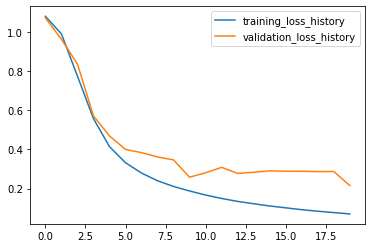

In [24]:
plt.plot(loss_tr1, label = "training_loss_history")
plt.plot(dev_loss1, label = "validation_loss_history")
plt.legend()
plt.show()

Explanation:
The model is OK with the selected the best hyperparameters. There is no any overfitting and/or underfitting problems. Training Loss are decreasing by every epoch. The model's learning process is not so long or short, so it is reasonable and acceptable considering whole data. The validation loss is fluctuating but it does not look an issue considering that this is a deep learning implementation since the scores are high and there is no overfitting 

In [25]:
preds_te_average = np.array([np.argmax(forward_pass(x, W1, dropout_rate=0.0)['prediction'])+1
            for x,y in zip(test_indices_final, test_arr_y)])

print('Accuracy:', accuracy_score(test_arr_y,preds_te_average))
print('Precision:', precision_score(test_arr_y,preds_te_average,average='macro'))
print('Recall:', recall_score(test_arr_y,preds_te_average,average='macro'))
print('F1-Score:', f1_score(test_arr_y,preds_te_average,average='macro'))

Accuracy: 0.8487208008898777
Precision: 0.8514313995561199
Recall: 0.8487105165366035
F1-Score: 0.8487458521279638


There are 27 different hyperparameter combinations (3 for each) checked in this model.
Embedding dimension, dropout rate and learning rate are considered as hyperparameters in this implementation. Grid search which is the simplest algorithm for hyperparameter tuning is applied to choose the best hyperparameters. Every combination of values of this grid is tried to find the best combination. The grid values are estimated manually (mostly taking the traditional values). To train the model efficiently, the dropout rate is set as a big range of percentage. This is to prevent the model from overfitting by regularization within the 20 epochs. Also, it can improve the generalization performance on test (unseen) data.
Embedding dimension is selected with the numbers up to 300 in traditional ways. To make the dimension so high increases the cost and also the benefit of the high dimension will be limited after a point.
Since the given learning rate is good enough to get desired scores, the number of epochs is limited by 20.
If the learning rates are small, it requires more epochs to make changes after each iteration/update. Also, the number of epochs (20) is the same for all model implementations. 

In [26]:
def get_glove_embeddings(f_zip, f_txt, vocab_id, emb_size=300):
    w_emb = np.zeros((len(vocab_id), emb_size))    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split(' ')[0]
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[vocab_id[word]] +=emb
    return w_emb

In [27]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab_id)

### Average Embedding (Pre-trained) 

In [28]:
W2, dropout_rate, lr, embedding_dim, comparison = hyper_params_glove(train_indices_final, train_arr_y_onehot,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            hidden_dim=[],
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=5)
for i in range(len(W2)):
    print('Shape W'+str(i), W2[i].shape)
    
print(('embedding_dim', embedding_dim), 
      ('dropout_rate', dropout_rate), 
      ('learning rate' ,lr))

Shape W0 (2000, 300)
Shape W1 (300, 3)
('embedding_dim', 300) ('dropout_rate', 0.5) ('learning rate', 0.01)


In [29]:
# hyperparameter combinations with their loss and accuracy  
comparison

train loss  train accuracy  validation loss  \
dropout rate learning rate                                                
0.5          0.0100           0.441359        0.876667         0.393515   
             0.0010           0.842249        0.845833         0.849701   
             0.0001           1.061291        0.578333         1.054426   
0.7          0.0100           0.548073        0.865417         0.570000   
             0.0010           0.954518        0.768750         0.942615   
             0.0001           1.079408        0.396667         1.081086   
0.8          0.0100           0.653128        0.835833         0.633410   
             0.0010           1.002938        0.710833         0.992430   
             0.0001           1.087198        0.378750         1.078008   

                            validation accuracy  
dropout rate learning rate                       
0.5          0.0100                    0.880000  
             0.0010                    0.866667  
             0.0001                    0.526667  
0.7          0.0100                    0.866667  
             0.0010                    0.740000  
             0.0001                    0.440000  
0.8          0.0100                    0.833333  
             0.0010                    0.700000  
             0.0001                    0.433333

In [30]:
W2, loss_tr2, dev_loss2 = SGD(train_indices_final, train_arr_y_onehot,
                            W2,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            lr=lr, 
                            dropout_rate=dropout_rate,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=20)

epoch:1   training_loss: 0.8432988763973117   validation_loss: 0.6752879132827123 
epoch:2   training_loss: 0.6058914583378161   validation_loss: 0.5441248442232609 
epoch:3   training_loss: 0.5166545316080252   validation_loss: 0.3995199767606599 
epoch:4   training_loss: 0.46965236628156465   validation_loss: 0.44903649238248666 
epoch:5   training_loss: 0.4413882156288795   validation_loss: 0.41642243673404056 
epoch:6   training_loss: 0.42100747124874033   validation_loss: 0.4002026483540734 
epoch:7   training_loss: 0.4060047984707247   validation_loss: 0.32441622419999194 
epoch:8   training_loss: 0.39504674864127687   validation_loss: 0.3687897468917072 
epoch:9   training_loss: 0.38628265432009357   validation_loss: 0.3206145608654389 
epoch:10   training_loss: 0.3781232411729191   validation_loss: 0.3575491914556672 
epoch:11   training_loss: 0.372364467302541   validation_loss: 0.2989966841414571 
epoch:12   training_loss: 0.3668457051566414   validation_loss: 0.3152587016423

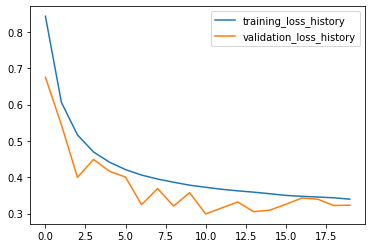

In [31]:
plt.plot(loss_tr2, label = "training_loss_history")
plt.plot(dev_loss2, label = "validation_loss_history")
plt.legend()
plt.show()

Explanation:
The model is OK with the selected the best hyperparameters. There is no any overfitting and/or underfitting problems. Training Loss are decreasing by every epoch. The model's learning process is not so long or short, so it is reasonable and acceptable considering whole data. The validation loss is fluctuating but it does not look an issue considering that this is a deep learning implementation since the scores are high and there is no overfitting 

In [32]:
preds_te_average_glove = np.array([np.argmax(forward_pass(x, W2, dropout_rate=0.0)['prediction'])+1
            for x,y in zip(test_indices_final, test_arr_y)])

print('Accuracy:', accuracy_score(test_arr_y,preds_te_average_glove))
print('Precision:', precision_score(test_arr_y,preds_te_average_glove,average='macro'))
print('Recall:', recall_score(test_arr_y,preds_te_average_glove,average='macro'))
print('F1-Score:', f1_score(test_arr_y,preds_te_average_glove,average='macro'))

Accuracy: 0.8665183537263627
Precision: 0.8692365056095128
Recall: 0.8665031586770717
F1-Score: 0.8668028093131895


The pre-trained model shows better performance than the first model which is trained randomly selected weights. Since GloVe uses global information and also it is able to derive relationship between unigrams(words) from statistics, this is what we expected.

There are 9 different hyperparameter combinations (3 for each) checked in this model.
Embedding dimension is fixed as 300 since the glove weights are used.
Dropout rate and learning rate are considered as hyperparameters in this implementation. Grid search which is the simplest algorithm for hyperparameter tuning is applied to choose the best hyperparameters. Every combination of values of this grid is tried to find the best combination. The grid values are estimated manually (mostly taking the traditional values). To train the model efficiently, the dropout rate is set as a big range of percentage. This is to prevent the model from overfitting by regularization within the 20 epochs. Also, it can improve the generalization performance on test (unseen) data.
Since the given learning rate is good enough to get desired scores, the number of epochs is limited by 20.
If the learning rates are small, it requires more epochs to make changes.

### Average Embedding (Pre-trained) + 1 hidden layers	

The hidden layer dimension is selected considering the vocabulary size (inputs) and the embedding hidden layer's size (embedding matrix size). Since the vocabulary size is 2000 and embedding layer size is 300 (glove embeddings), the hidden layer size is considered as also 300. Hidden layers with so many neurons can make the model more complex and provide high scores. However, its benefit will be limited after a point. On the other hand, more neurons causes cost and running time issues. In this implementation, as there is no running time issue 300 neurons are selected considering the criterias explained above. In addition to this, because the scores obtained from the model are enough, only 1 hidden layer is considered to decrease cost. 

In [33]:
W3, dropout_rate, lr,embedding_dim, comparison = hyper_params_glove(train_indices_final, train_arr_y_onehot,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            hidden_dim=[300],
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=5)

for i in range(len(W3)):
    print('Shape W'+str(i), W3[i].shape)
    
print(('embedding_dim', embedding_dim), 
      ('dropout_rate', dropout_rate), 
      ('learning rate' ,lr))

Shape W0 (2000, 300)
Shape W1 (300, 300)
Shape W2 (300, 3)
('embedding_dim', 300) ('dropout_rate', 0.5) ('learning rate', 0.01)


In [34]:
# hyperparameter combinations with their loss and accuracy  
comparison

train loss  train accuracy  validation loss  \
dropout rate learning rate                                                
0.5          0.0100           0.317360        0.902917         0.318387   
             0.0010           0.799459        0.854583         0.805048   
             0.0001           1.073075        0.499167         1.070207   
0.7          0.0100           0.361116        0.867500         0.372395   
             0.0010           1.045193        0.625833         1.041617   
             0.0001           1.095498        0.357083         1.089302   
0.8          0.0100           0.429061        0.847500         0.475645   
             0.0010           1.078052        0.638333         1.086977   
             0.0001           1.097592        0.345833         1.093047   

                            validation accuracy  
dropout rate learning rate                       
0.5          0.0100                    0.873333  
             0.0010                    0.840000  
             0.0001                    0.546667  
0.7          0.0100                    0.840000  
             0.0010                    0.566667  
             0.0001                    0.393333  
0.8          0.0100                    0.806667  
             0.0010                    0.653333  
             0.0001                    0.393333

In [35]:
W3, loss_tr3, dev_loss3 = SGD(train_indices_final, train_arr_y_onehot,
                            W3,
                            X_dev=dev_indices_final, 
                            Y_dev=dev_arr_y_onehot,
                            lr=lr, 
                            dropout_rate=dropout_rate,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=20)

epoch:1   training_loss: 0.7745230086923888   validation_loss: 0.4362691030402978 
epoch:2   training_loss: 0.40471269843517804   validation_loss: 0.42221437996177347 
epoch:3   training_loss: 0.35450747627927437   validation_loss: 0.3336132396615937 
epoch:4   training_loss: 0.33249395004226245   validation_loss: 0.36130843326503775 
epoch:5   training_loss: 0.3163937927120302   validation_loss: 0.2978215486794824 
epoch:6   training_loss: 0.3045736911766714   validation_loss: 0.14345703947668273 
epoch:7   training_loss: 0.2922303992371659   validation_loss: 0.2753233848690835 
epoch:8   training_loss: 0.2833378994741209   validation_loss: 0.29900015408781416 
epoch:9   training_loss: 0.2794564246667111   validation_loss: 0.28593289956601486 
epoch:10   training_loss: 0.2691329125945625   validation_loss: 0.2749489961781216 
epoch:11   training_loss: 0.262970093192298   validation_loss: 0.2299156928768482 
epoch:12   training_loss: 0.25701537796495794   validation_loss: 0.36032206872

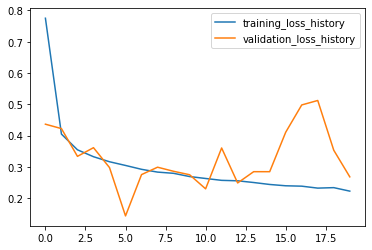

In [36]:
plt.plot(loss_tr3, label = "training_loss_history")
plt.plot(dev_loss3, label = "validation_loss_history")
plt.legend()
plt.show()

Explanation:
The model is OK with the selected the best hyperparameters. There is no any overfitting and/or underfitting problems. Training Loss are decreasing by every epoch. The model's learning process is not so long or short, so it is reasonable and acceptable considering whole data. The validation loss is fluctuating but it does not look an issue considering that this is a deep learning implementation since the scores are high and there is no overfitting 

In [37]:
preds_te_average_glove_hid = np.array([np.argmax(forward_pass(x, W3, dropout_rate=0.0)['prediction'])+1
            for x,y in zip(test_indices_final, test_arr_y)])

print('Accuracy:', accuracy_score(test_arr_y,preds_te_average_glove_hid))
print('Precision:', precision_score(test_arr_y,preds_te_average_glove_hid,average='macro'))
print('Recall:', recall_score(test_arr_y,preds_te_average_glove_hid,average='macro'))
print('F1-Score:', f1_score(test_arr_y,preds_te_average_glove_hid,average='macro'))

Accuracy: 0.8765294771968855
Precision: 0.8782407003883513
Recall: 0.8765031586770716
F1-Score: 0.87701146147363


MODEL PERFORMANCE: It can be seen that the deeper architectures increased performance as expected. Since hidden layers make the network more deep, high scores are available. Basically, hidden layers enhance the order of weights, so it is possible to get the best decision boundary. Also, a hidden layer with 300 neurons which is good to have a capable model makes the network able to capture more complexity.

HYPER PARAMETERS: There are 9 different hyperparameter combinations (3 for each) checked in this model.
Embedding dimension is fixed as 300 since the glove weights are used.
Dropout rate and learning rate are considered as hyperparameters in this implementation. Grid search which is the simplest algorithm for hyperparameter tuning is applied to choose the best hyperparameters. Every combination of values of this grid is tried to find the best combination. The grid values are estimated manually (mostly taking the traditional values). To train the model efficiently, the dropout rate is set as a big range of percentage. This is to prevent the model from overfitting by regularization within the 20 epochs. Also, it can improve the generalization performance on test (unseen) data.
Since the given learning rate is good enough to get desired scores, the number of epochs is limited by 20.
If the learning rates are small, it requires more epochs to make changes.

In [38]:
data = {'Precision' :[precision_score(test_arr_y,preds_te_average,average='macro'),
                      precision_score(test_arr_y,preds_te_average_glove,average='macro'),
                      precision_score(test_arr_y,preds_te_average_glove_hid,average='macro')],
        'Recall' :[recall_score(test_arr_y,preds_te_average,average='macro'),
                   recall_score(test_arr_y,preds_te_average_glove,average='macro'),
                   recall_score(test_arr_y,preds_te_average_glove_hid,average='macro')],
        'F1-Score' :[f1_score(test_arr_y,preds_te_average,average='macro'),
                     f1_score(test_arr_y,preds_te_average_glove,average='macro'),
                     f1_score(test_arr_y,preds_te_average_glove_hid,average='macro')],
       'Accuracy' : [accuracy_score(test_arr_y,preds_te_average),
                     accuracy_score(test_arr_y,preds_te_average_glove),
                     accuracy_score(test_arr_y,preds_te_average_glove_hid)]}
index = ['Average Embedding', 'Average Embedding (Pre-trained)', 'Average Embedding (Pre-trained) + 1 Hidden Layers']
full_results = pd.DataFrame(data, index = index)
full_results

,Precision,Recall,F1-Score,Accuracy
Average Embedding,0.851431,0.848711,0.848746,0.848721
Average Embedding (Pre-trained),0.869237,0.866503,0.866803,0.866518
Average Embedding (Pre-trained) + 1 Hidden Layers,0.878241,0.876503,0.877011,0.876529


As seen in the final result table above, the best model is "Average Embedding (Pre-trained) + 1 Hidden Layers" in terms of all scores. This is what we expected since this model has one more hidden layer with 300 neurons so the neural network is more deep compared to the first two models. Additional hidden layer makes the network more complex. It means there are more relations about the inputs compared to the first 2 models. It looks like there is no big difference between all these 3 models but when the data is huge and/or the result of performance is related to sensitive time requirements and/or cost, the best model will provide more benefit.

To sum up, the best model has initialized with the pre-trained glove weights comparing with the first (Average Embedding) model. GloVe uses global information and also it is able to derive relationship between unigrams(words) from statistics. Also the best model has one more hidden layer with 300 neurons (which is well enough to get complexity and more relationship) comparing with the second (Average Embedding (Pre-trained) model. That's why all scores of this model are higher than others.

Note: Whole implementation process (including hyperparameters tuning and running glove function) takes 10 minutes. 